# Processing

In [586]:
import pandas as pd
import numpy as np
np.set_printoptions(suppress=True) # Suppress scientific notation where possible

# import data visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import figure
%config InlineBackend.figure_formats = ['svg']
sns.set(context='notebook', style='whitegrid')

#https://www.kaggle.com/chethan187/ensemble-techniques

import warnings
warnings.filterwarnings('ignore')

# import data modelling libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import sklearn.metrics as metrics


In [587]:
df = pd.read_csv('data.csv')
df.head()

,age,job,marital,education,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,3,1,0,0,0,1,6,1,1,999,0,1,93.994,-36.4,4.857,0
1,57,7,1,3,0,0,1,6,1,1,999,0,1,93.994,-36.4,4.857,0
2,37,7,1,3,1,0,1,6,1,1,999,0,1,93.994,-36.4,4.857,0
3,40,0,1,1,0,0,1,6,1,1,999,0,1,93.994,-36.4,4.857,0
4,56,7,1,3,0,1,1,6,1,1,999,0,1,93.994,-36.4,4.857,0


In [588]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38205 entries, 0 to 38204
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             38205 non-null  int64  
 1   job             38205 non-null  int64  
 2   marital         38205 non-null  int64  
 3   education       38205 non-null  int64  
 4   housing         38205 non-null  int64  
 5   loan            38205 non-null  int64  
 6   contact         38205 non-null  int64  
 7   month           38205 non-null  int64  
 8   day_of_week     38205 non-null  int64  
 9   campaign        38205 non-null  int64  
 10  pdays           38205 non-null  int64  
 11  previous        38205 non-null  int64  
 12  poutcome        38205 non-null  int64  
 13  cons.price.idx  38205 non-null  float64
 14  cons.conf.idx   38205 non-null  float64
 15  euribor3m       38205 non-null  float64
 16  y               38205 non-null  int64  
dtypes: float64(3), int64(14)
memory

#### Split Data Into Train and Test

In [589]:
# We will divide the training and testing set in 80% and 20% respectively
# We used random_state = 100 so that everytime we run it we will have same set of training and testing set

df_train, df_test = train_test_split(df, train_size = 0.8, random_state = 100)

In [590]:
df_train.shape, df_test.shape

((30564, 17), (7641, 17))

#### Dividing into X and Y sets for the model building

In [591]:
# Divide the train data into X and y

y_train = df_train.pop('y')
X_train = df_train

In [592]:
# Divide the test data into X and y

y_test = df_test.pop('y')
X_test = df_test

In [593]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((30564, 16), (30564,), (7641, 16), (7641,))

# Modeling

## Base Model: Logistic Regression

In [594]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Our data is not normally distributed so we will use StandardScaler for rescaling the continuous variables
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logit_model = LogisticRegression(solver='liblinear')
LG_model = logit_model.fit(X_train, y_train)

logit_predict = logit_model.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, LG_model.predict_proba(X_test)[:,1])

print("Confusion Matrix: \n\n", 
      confusion_matrix(y_test, logit_predict))

print("Classification Report for Logistic Regression: \n\n", 
      classification_report(y_test, logit_predict))                                                     

LogitRegression = (cross_val_score(logit_model, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy').mean())

Logit_F1 = round(f1_score(logit_predict, y_test), 5)
Logit_F1

Confusion Matrix: 

 [[6736   80]
 [ 642  183]]
Classification Report for Logistic Regression: 

               precision    recall  f1-score   support

           0       0.91      0.99      0.95      6816
           1       0.70      0.22      0.34       825

    accuracy                           0.91      7641
   macro avg       0.80      0.61      0.64      7641
weighted avg       0.89      0.91      0.88      7641



0.3364

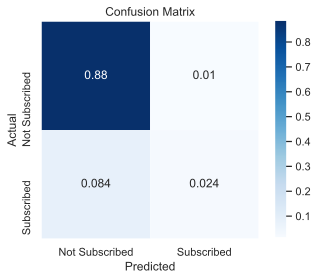

In [595]:
def plot_cm(y_true, y_pred, figsize=(8,6)):
    cm = confusion_matrix(y_test, logit_predict, normalize='all')

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
plot_cm(y_test, logit_predict)
plt.savefig('charts/confussion_matrix_log_pred.png')

## Logistic Regression Threshold

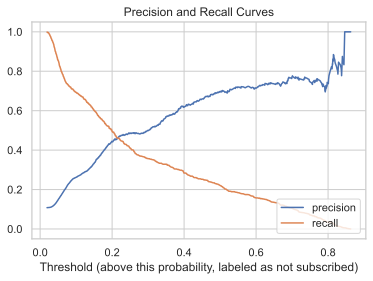

In [596]:
#precision/recall graph LG_model

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, LG_model.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower right')
plt.xlabel('Threshold (above this probability, labeled as not subscribed)');
plt.title('Precision and Recall Curves');

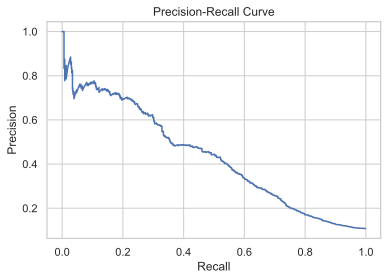

In [597]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

Logistic Regression Model best F1 score 0.469 at prob decision threshold >= 0.205


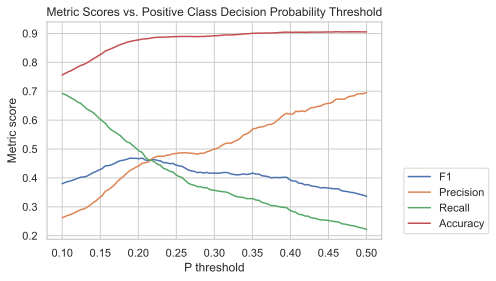

In [598]:
plt.figure(dpi=80)

X_val, y_val = X_test, y_test # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.5,100)
model_val_probs = LG_model.predict_proba(X_val)[:,1]# positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

LG_best_f1_score = np.max(f1_scores) 
LG_best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Logistic Regression Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (LG_best_f1_score, LG_best_thresh_p))
plt.savefig('charts/logit_metric_scores.png', bbox_inches='tight')

## Logistic Regression Class Weights 10:1

In [599]:
from sklearn.model_selection import GridSearchCV

In [600]:
# define weight hyperparameter
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
hyperparam_grid = {"class_weight": w }

In [601]:
# define model
LG = LogisticRegression(random_state=13)
# define evaluation procedure
grid = GridSearchCV(LG,hyperparam_grid,scoring="roc_auc", cv=100, n_jobs=-1, refit=True)
grid.fit(X_train, y_train)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

Best score: 0.7689947751457866 with param: {'class_weight': {0: 1.0, 1: 10}}


In [602]:
lr_10x = LogisticRegression(class_weight={0: 1.0, 1: 10}, solver='liblinear')

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_10x.fit(X_train, y_train)
print('10:1 class weights Logistic Regression Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_test, lr_10x.predict(X_test)), roc_auc_score(y_test, lr_10x.predict_proba(X_test)[:,1])))

10:1 class weights Logistic Regression Test F1: 0.373, Test AUC: 0.776


## Logistic Regression (weigh class 'balanced')

Logistic Regression: A Supervised classification algorithm. It used Sigmoid function for classifying the binary labelled output variables.

In [603]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

#Our data is not normally distributed so we will use StandardScaler for rescaling the continuous variables
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

logit_model_bal = LogisticRegression(class_weight="balanced", solver='liblinear')
LG_model_bal = logit_model_bal.fit(X_train, y_train)

logit_predict_bal = logit_model_bal.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, LG_model_bal.predict_proba(X_test)[:,1])

print("Confusion Matrix: \n\n", 
      confusion_matrix(y_test, logit_predict_bal))

print("Classification Report for Logistic Regression (Class_Weight): \n\n",
      classification_report(y_test, logit_predict_bal))                                                     

LogitRegression_bal = (cross_val_score(logit_model_bal, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy').mean())

Logit_bal_F1 = round(f1_score(logit_predict_bal, y_test), 5)
Logit_bal_F1

Confusion Matrix: 

 [[5319 1497]
 [ 261  564]]
Classification Report for Logistic Regression (Class_Weight): 

               precision    recall  f1-score   support

           0       0.95      0.78      0.86      6816
           1       0.27      0.68      0.39       825

    accuracy                           0.77      7641
   macro avg       0.61      0.73      0.62      7641
weighted avg       0.88      0.77      0.81      7641



0.39085

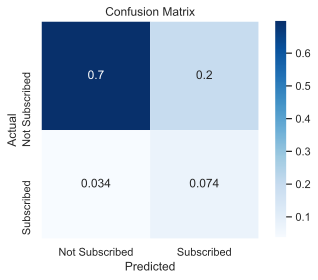

In [604]:
def plot_cm(y_true, y_pred, figsize=(8,6)):
    cm = confusion_matrix(y_test, logit_predict_bal, normalize='all')

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
plot_cm(y_test, logit_predict_bal)
plt.savefig('charts/confussion_matrix_log_pred.png', bbox_inches='tight')


## Random Forest (class_weight='balanced')

Random Forest: A random forest is a meta estimator that fits a nummber of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting

In [605]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

rfcl_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=None, class_weight='balanced')
RF_model = rfcl_model.fit(X_train, y_train)

rf_predict = rfcl_model.predict(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, RF_model.predict_proba(X_test)[:,1])

print("Confusion Matrix: \n\n", 
      confusion_matrix(y_test, rf_predict))

print("Classification Report for Random Forest: \n\n",
      classification_report(y_test, rf_predict))

RandomForest = (cross_val_score(rfcl_model, X_train, y_train, cv=k_fold, n_jobs=1, scoring='accuracy').mean())

RF_F1 = round(f1_score(rf_predict, y_test), 5)
RF_F1

Confusion Matrix: 

 [[6187  629]
 [ 368  457]]
Classification Report for Random Forest: 

               precision    recall  f1-score   support

           0       0.94      0.91      0.93      6816
           1       0.42      0.55      0.48       825

    accuracy                           0.87      7641
   macro avg       0.68      0.73      0.70      7641
weighted avg       0.89      0.87      0.88      7641



0.47828

Notes on Results:

- Random Forest F1 Score is performed 26% better than Logistic Regression class_weight = 'balanced'

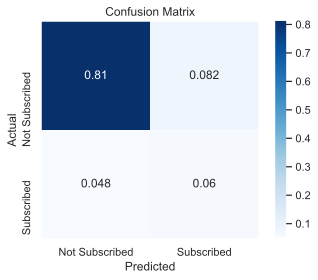

In [606]:
def plot_cm(y_true, y_pred, figsize=(8,6)):
    cm = confusion_matrix(y_test, rf_predict, normalize='all')

    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, square=True, xticklabels=['Not Subscribed', 'Subscribed'], yticklabels=['Not Subscribed', 'Subscribed'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    
plot_cm(y_test, rf_predict)
plt.savefig('charts/confussion_matrix_rf_predict.png', bbox_inches='tight')

## Random Forest Threshold

In [607]:
# Let's calculate the exact Threshold just for refencencial comparison to P Threshold

def find_best_thresh(model, X, y):
    
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, RF_model.predict_proba(X_test)[:,1] )

    # identify best threshold
    idx = np.argmin(np.abs(precision_curve - recall_curve))
    best_threshold = threshold_curve[idx]
    
    return best_threshold

RF_best_thresh = round(find_best_thresh(RF_model, X_val, y_val),4)

print(f'RF_best_thresh: {RF_best_thresh}')

RF_best_thresh: 0.6167


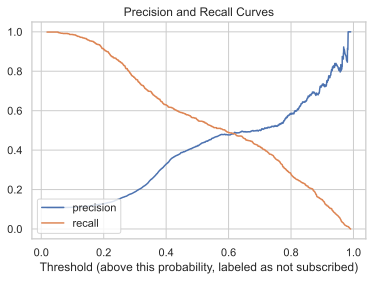

In [608]:
#precision/recall graph RF_model

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, RF_model.predict_proba(X_test)[:,1] )
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, labeled as not subscribed)');
plt.title('Precision and Recall Curves');

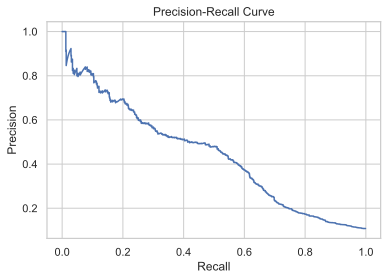

In [609]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

#### Presicion_Recall Curve

- A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate.

Random Forest Model best F1 score 0.493 at prob decision threshold >= 0.574


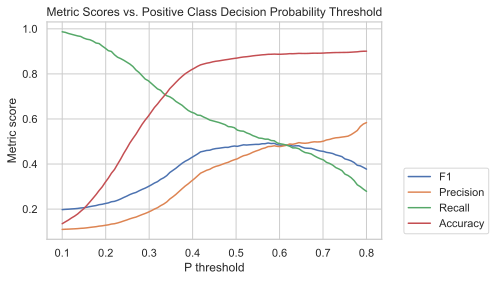

In [610]:
plt.figure(dpi=80)

X_val, y_val = X_test, y_test                                   # explicitly calling this validation since we're using it for selection

thresh_ps = np.linspace(.10,.8,100)
model_val_probs = RF_model.predict_proba(X_val)[:,1]             # positive class probs, same basic logistic model we fit in section 2 

f1_scores, prec_scores, rec_scores, acc_scores = [], [], [], []
for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))    
    prec_scores.append(precision_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    acc_scores.append(accuracy_score(y_val, model_val_labels))
    
plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, prec_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, acc_scores)

plt.title('Metric Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1','Precision','Recall','Accuracy'], bbox_to_anchor=(1.05, 0), loc='lower left')
plt.xlabel('P threshold')
plt.ylabel('Metric score')

RF_best_f1_score = np.max(f1_scores) 
RF_best_thresh_p = thresh_ps[np.argmax(f1_scores)]

print('Random Forest Model best F1 score %.3f at prob decision threshold >= %.3f' 
      % (RF_best_f1_score, RF_best_thresh_p))
plt.savefig('charts/RF_metric_scores.png', bbox_inches='tight')

### Compare performances of all the models

In [611]:
base_models = pd.DataFrame({'Models': ['LogitRegression', 'LogitRegression_bal', 'RandomForest'],
                       'Balanced F1 Scores': [Logit_F1, Logit_bal_F1, RF_F1]})
base_models.sort_values(by='Balanced F1 Scores', ascending = False)

,Models,Balanced F1 Scores
2,RandomForest,0.47828
1,LogitRegression_bal,0.39085
0,LogitRegression,0.33640


In [612]:
models = pd.DataFrame({'Tuned Models': ['LogitRegression', 'LogitRegression_bal', 'RandomForest'],
                       'Threshold F1 Scores': [LG_best_f1_score, LG_balanced_best_f1_score, RF_best_f1_score]})
models.sort_values(by='Threshold F1 Scores', ascending = False)

,Tuned Models,Threshold F1 Scores
2,RandomForest,0.493263
1,LogitRegression_bal,0.471360
0,LogitRegression,0.468877


### Best F1 Score:   Random Forest Threshold Tuned = 0.49 

Note that Random Forest F1 score is almost exactly the same in both cases: weight_class='balanced' and Threshold. That tell us we did agood job with the parameters when Instantiating our Random Forest Classifier model

# ROC-AUC Comparison

Random Forest ROC AUC score =  0.779208279982928


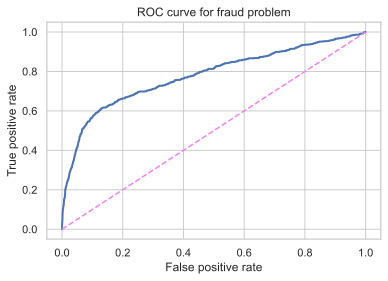

In [613]:
# RF Model

# Precision = TP / (TP + FP)
# Recall = TP/P = True positive rate
# false positive rate = FP / true negatives = FP / (FP + TN) 

fpr, tpr, thresholds = roc_curve(y_test, RF_model.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("Random Forest ROC AUC score = ", roc_auc_score(y_test, RF_model.predict_proba(X_test)[:,1]))

Logistic Regression Bal ROC AUC score =  0.7759961409873382


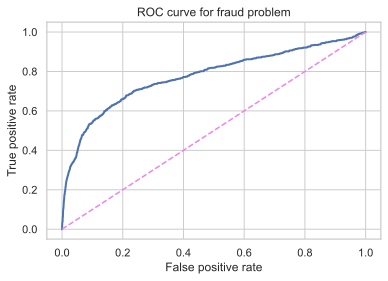

In [614]:
fpr, tpr, thresholds = roc_curve(y_test, LG_model_bal.predict_proba(X_test)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("Logistic Regression Bal ROC AUC score = ", roc_auc_score(y_test, LG_model_bal.predict_proba(X_test)[:,1]))


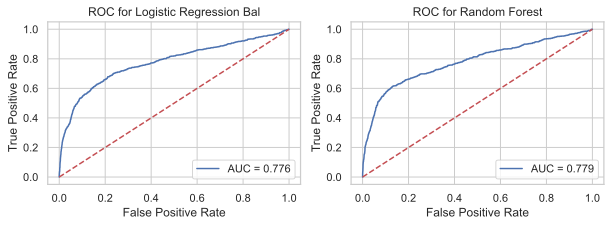

In [615]:
plt.figure(figsize=(10,3))

probs = LG_model_bal.predict_proba(X_test)                            #ROC Curve for Logistic Regression Bal
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.subplot(1,2,1)
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Logistic Regression Bal')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')


probs = RF_model.predict_proba(X_test)                                 #ROC Curve for Random Forest 
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.subplot(1,2,2)
plt.plot(fpr, tpr, 'b', label= 'AUC = %0.3f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC for Random Forest')
plt.legend(loc = 'lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');
plt.savefig('charts/ROC_comparison.png', bbox_inches='tight')

### When will you prefer F1 over ROC-AUC?

When you have a small positive class, then F1 score makes more sense. This is the common problem in fraud detection where positive labels are few.

Some important characteristics of ROC-AUC are:

The value can range from 0 to 1. However auc score of a random classifier for balanced data is 0.5
ROC-AUC score is independent of the threshold set for classification because it only considers the rank of each prediction and not its absolute value. The same is not true for F1 score which needs a threshold value in case of probabilities output

## Log Loss Cross-Entropy

The cost function typically used for Gradient Descent on classification is log-loss-cross-entropy! 

Log loss is an essential metric that defines the numerical value bifurcation between the presumed probability label and the true one, expressing it in values between zero and one. 

>- Log-loss allows us to measure not just "did our model get XYZ right?" but "how confident was it when predicting?"
>- This function is mostly used to train binary classifiers, relatively simple tasks with two accurate and inaccurate labels. 
>- The lower the log loss, the more accurate predictions your AI will make, meaning its overall accuracy and functionality will rise. 

Without log loss, the artificial intelligence that enables many of our day-to-day activities wouldn’t make proper decisions, making it less than ideal for commercial applications. 


In [616]:
from sklearn.metrics import log_loss

In [617]:
print("Logistic Regression Log-loss on logit: {:6.4f}".format(log_loss(y_test, LG_model.predict_proba(X_test))))
LG_log_loss = round(log_loss(y_test, LG_model.predict_proba(X_test)), 4)
LG_log_loss

Logistic Regression Log-loss on logit: 0.2756


0.2756

In [618]:

print("Logistic Regression Balanced Log-loss on logit: {:6.4f}".format(log_loss(y_test, LG_model_bal.predict_proba(X_test))))
LG_bal_log_loss = round(log_loss(y_test, LG_model_bal.predict_proba(X_test)), 4)
LG_bal_log_loss

Logistic Regression Balanced Log-loss on logit: 0.5394


0.5394

In [619]:
print("Random Forest Log-loss on logit: {:6.4f}".format(log_loss(y_test, RF_model.predict_proba(X_test))))
RF_log_loss = round(log_loss(y_test, RF_model.predict_proba(X_test)), 4)
RF_log_loss

Random Forest Log-loss on logit: 0.4396


0.4396

The Random Forest outperforms the Logistic here (since it's much smarter about its "how confident am I") despite not really outperforming the Logistic model much in accuracy.

## Log Loss performance comparison 

In [620]:
models = pd.DataFrame({'Models': [ 'LogitRegression_Bal', 'RandomForest'],
                       'Log Loss': [LG_bal_log_loss, RF_log_loss]})
models.sort_values(by='Log Loss', ascending = True)           #closer to cero is better

,Models,Log Loss
1,RandomForest,0.4396
0,LogitRegression_Bal,0.5394


https://www.kdnuggets.com/2018/06/right-metric-evaluating-machine-learning-models-2.html

### Comparison of Log-loss with ROC & F1

Inferences drawn from the above resuls (balanced):

- If you care for absolute probabilistic difference, go with log-loss
- If you care only for the final class prediction and you don’t want to tune threshold, go with AUC score
- F1 score is sensitive to threshold and you would want to tune it first before comparing the models. Since we tuned our thresholds already for all models, we will finally go with Random Forest Threshold F1 Score 0.49

### Overfitting and Underfitting check point

In [621]:
logit_model = LogisticRegression(class_weight="balanced", solver='liblinear')
LG_model = logit_model.fit(X_train, y_train)
print("The score for logit is")
print("Training: {:6.2f}%".format(100*LG_model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*LG_model.score(X_test, y_test)))

The score for logit is
Training:  76.85%
Test set:  76.99%


In [622]:
rfcl_model = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=None, class_weight='balanced')
RF_model = rfcl_model.fit(X_train, y_train)
print("The score for RF is")
print("Training: {:6.2f}%".format(100*RF_model.score(X_train, y_train)))
print("Test set: {:6.2f}%".format(100*RF_model.score(X_test, y_test)))

The score for RF is
Training:  89.21%
Test set:  87.29%


- Accuracy scored well on training and test data so we had no issues of overfitting/underfitting.

# Conclusions:
    
- From all the above classification models, Random Forest performed better with F1 score of 0.49 with 45% better performance than the basic Logistic Regression model which scored an F1 of 0.37 with inbalance problems. The game changer on getting this optimization was adjunting the threshold as a method to tackle the imbalanced target. 

- On the other hand, AUC-ROC scores for both models were very similar with AUC=77% for Logistic Regression and AUC=78% for Random Forest

- Accuracy for training and test sets were almost the same for both models which dismiss Overfitting or Underfitting.

- Finally Log Loss was applied, which a more intensive metric for measuring the confidence of our predictions. With the assumption that a lower log-loss is better, we confirmed that Random Forest was the best score as well, with a Log Loss = 0.44 with a 19% better score that Logistic Regression call-weight='balanced'.
 